# Введение
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

# План работы
1) Изучение общей информации\
2) Предобработка данных\
3) Исследовательский анализ данных\
4) Составление портрета пользователя каждого региона\
5) Проверка гипотез\
6) Подведение итогов

# Описание данных
`Name` — название игры\
`Platform` — платформа\
`Year_of_Release` — год выпуска\
`Genre` — жанр игры\
`NA_sales` — продажи в Северной Америке (миллионы проданных копий)\
`EU_sales` — продажи в Европе (миллионы проданных копий)\
`JP_sales` — продажи в Японии (миллионы проданных копий)\
`Other_sales` — продажи в других странах (миллионы проданных копий)\
`Critic_Score` — оценка критиков (максимум 100)\
`User_Score` — оценка пользователей (максимум 10)\
`Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
data.shape

(16715, 11)

In [4]:
rows = len(data.axes[0])
rows

16715

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
report = data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)*100
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
Critic_Score,8578,51.0
Rating,6766,40.0
User_Score,6701,40.0
Year_of_Release,269,2.0
Name,2,0.0
Genre,2,0.0
Platform,0,0.0
NA_sales,0,0.0
EU_sales,0,0.0
JP_sales,0,0.0


In [7]:
data.duplicated().sum()

0

В ходе обзора данных были изучены первые строки датафрейма, его размеры, тип значений столбцов и количество значений в них. После обзора можно сказать, что в датафрейме во некоторых столбцах присутствуют пропуски и указан неправильный тип данных. Явные дубликаты отсутствуют.

## Предобработка данных

In [8]:
data.columns = data.columns.str.lower() #приведём названия столбцов к нижнему регистру

In [9]:
data = data.dropna(subset = ['name']) #Удаляем пропуски в столбцах с пропущенным названием и жанром
data = data.dropna(subset = ['year_of_release']) #Удаляем пропуски в столбцах с пропущенным годом релиза
data['critic_score'] = data['critic_score'].fillna('unknown') #Заполняем пропуски в столбце с оценками критиков медианными значениями
data['user_score'] = data['user_score'].replace('tbd', np.NaN) #TBD — сокращение от To Be Determined. Служит для отметки неясностей или пропусков, которые надо заполнить, поэтому переобозначим за пропуск
data['user_score'] = data['user_score'].fillna('unknown') #Заполняем пропуски в столбце с оценками пользователей медианными значениями
data['rating'] = data['rating'].fillna('unknown')  #Вместо пропусков пишем слово неизвестно (заполнить нельзя, но и удалять тоже, так как количество пропусков слишком велико)
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format = '%Y') #Тип данных в столбце с годом меняем на соответсвующий

В стобце `name` есть 2 пропуска, но сделать с ними мы ничего не можем, поэтому данные строки удаляем. В столбцах с оценкой критиков/пользователей пишем вместо пропусков unknown. Далее, в столбцах `year_of_release` также удаляем пропуски, а в стобце `rating` вместо пропусков пишем слово неизвестно (заполнить нельзя, но и удалять тоже, так как количество пропусков слишком велико). Причины появления пропусков могут быть различными: возможно просто забыли указать какую-либо информацию, возможно произошла какая-то ошибка при выгрузке данных, а может быть и просто данные не известны (например год выхода игры)

In [10]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [11]:
#Проверим 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16444 non-null  object        
 1   platform         16444 non-null  object        
 2   year_of_release  16444 non-null  datetime64[ns]
 3   genre            16444 non-null  object        
 4   na_sales         16444 non-null  float64       
 5   eu_sales         16444 non-null  float64       
 6   jp_sales         16444 non-null  float64       
 7   other_sales      16444 non-null  float64       
 8   critic_score     16444 non-null  object        
 9   user_score       16444 non-null  object        
 10  rating           16444 non-null  object        
 11  all_sales        16444 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 1.6+ MB


In [12]:
report = data.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)*100
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
name,0,0.0
platform,0,0.0
year_of_release,0,0.0
genre,0,0.0
na_sales,0,0.0
eu_sales,0,0.0
jp_sales,0,0.0
other_sales,0,0.0
critic_score,0,0.0
user_score,0,0.0


In [13]:
rows_new = len(data.axes[0])
rows_new

16444

In [14]:
100-(rows_new/rows*100)

1.6212982351181608

Было удалено менее 2% данных из датафрейма, что является допустимым

В рамках данного этапа работы были обработаны пропущенные значения, типы данных в стобцах были приведены к корректным и добавлен новый столбец с итоговой прибылью

## Исследовательский анализ данных

### Количество игр, выпущенные в различные года

In [15]:
data.groupby('year_of_release')['name'].count() #Количество выпущенных игр в каждый год

year_of_release
1980-01-01       9
1981-01-01      46
1982-01-01      36
1983-01-01      17
1984-01-01      14
1985-01-01      14
1986-01-01      21
1987-01-01      16
1988-01-01      15
1989-01-01      17
1990-01-01      16
1991-01-01      41
1992-01-01      43
1993-01-01      60
1994-01-01     121
1995-01-01     219
1996-01-01     263
1997-01-01     289
1998-01-01     379
1999-01-01     338
2000-01-01     350
2001-01-01     482
2002-01-01     829
2003-01-01     775
2004-01-01     762
2005-01-01     939
2006-01-01    1006
2007-01-01    1197
2008-01-01    1427
2009-01-01    1426
2010-01-01    1255
2011-01-01    1136
2012-01-01     653
2013-01-01     544
2014-01-01     581
2015-01-01     606
2016-01-01     502
Name: name, dtype: int64

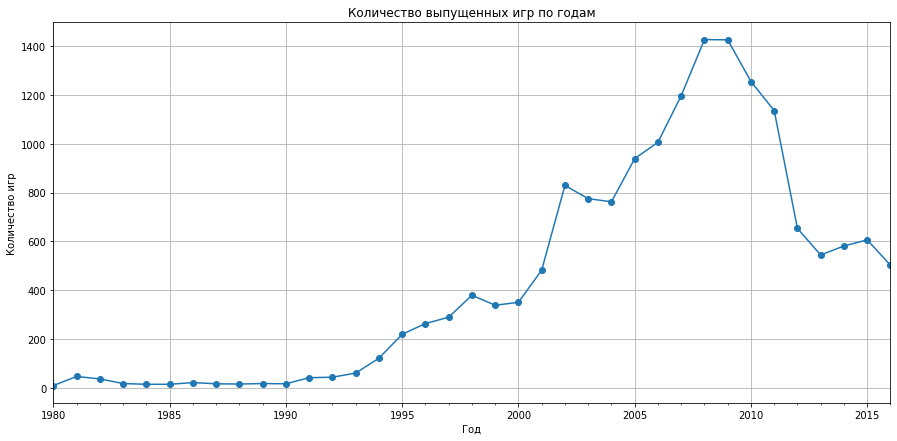

In [16]:
data.groupby('year_of_release')['name'].count().plot(style = 'o-', figsize = (15, 7), grid = True)
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

Пик, выпущенных игр приходится 2008-2009 года, далее количество идёт на спад.

### Продажи по платформам

In [17]:
data.groupby('platform')['all_sales'].sum().sort_values(ascending = False) #Продажи игр на каждой из платформ

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.76
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: all_sales, dtype: float64

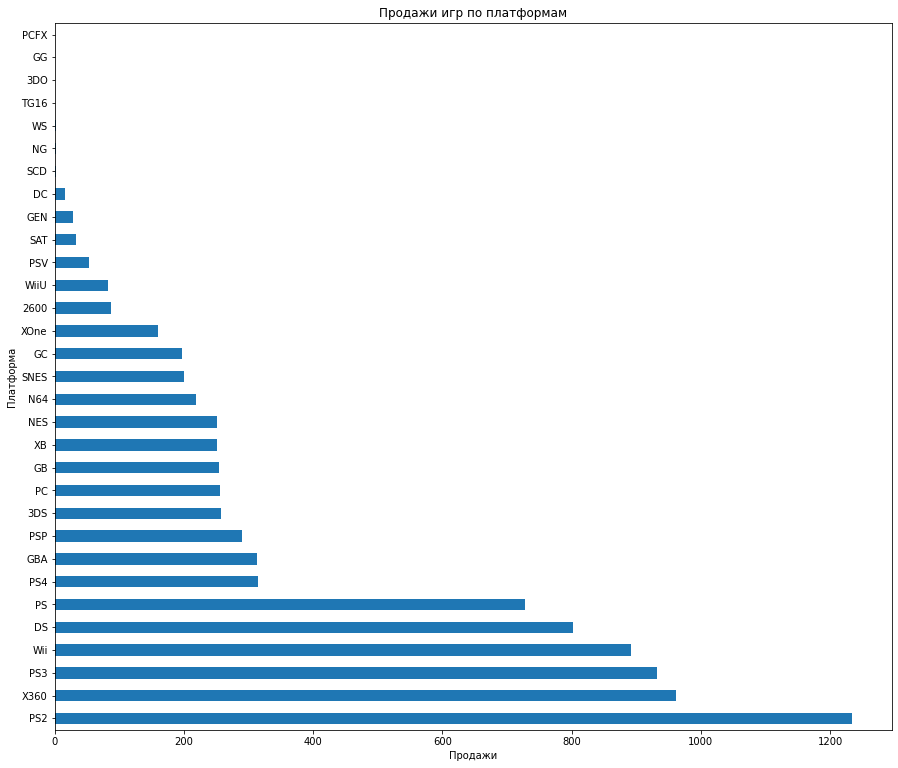

In [18]:
data.groupby('platform')['all_sales'].sum().sort_values(ascending = False).plot(kind = 'barh', figsize = (15, 13))
plt.xlabel('Продажи')
plt.ylabel('Платформа')
plt.title('Продажи игр по платформам')
plt.show()

Наибольшее количество продаж на платформах PS2, X360 и PS3, наименьшее - PCFX.\
Изучим две наиболее популярные платформы

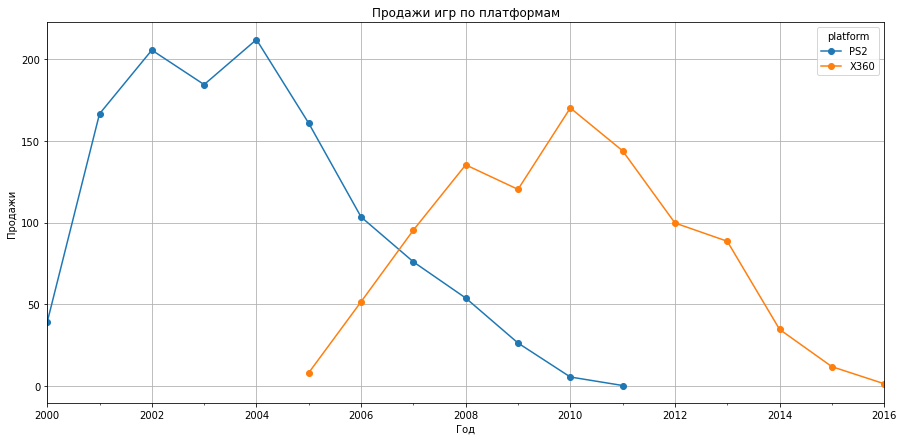

In [19]:
data.query('platform == ["PS2", "X360"]').pivot_table(index='year_of_release', columns = 'platform', values='all_sales', aggfunc='sum').plot(grid=True, figsize=(15, 7), style = 'o-')
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.title('Продажи игр по платформам')
plt.show()

Срок жизни платформы довольно продолжительный (PS2 появилось раньше 2000 года, и просуществовала до 2011; X360 с 2005 по 2016 год минимум, т.е. 11 лет), однако пик популярности консоли 1-2 года, после чего популярность идёт на спад, ибо выходят новые модели. При этом и до пика, популярность растёт, но не всегда велика, скорее всего это связано с тем, что не все сразу хотят пересаживаться на новые устройства. Поэтому для нашего анализа мы возьмём период в 3 года.

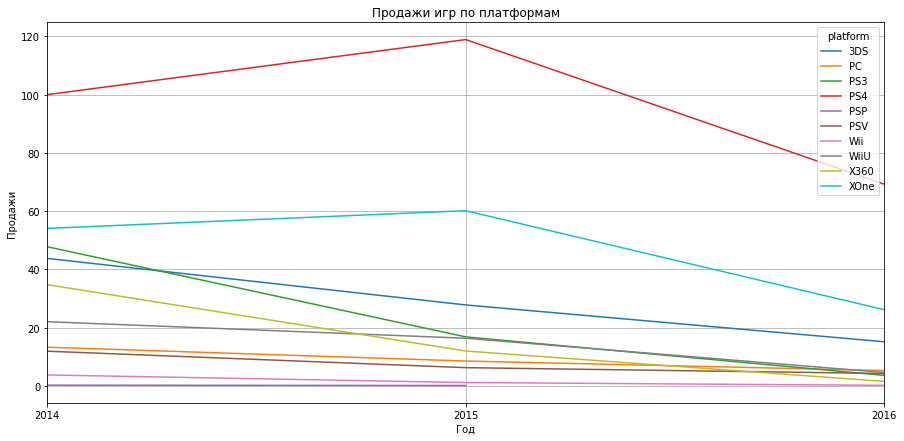

In [20]:
data_1516 = data.query('2014 <= year_of_release <= 2016')
data_1516.pivot_table(index='year_of_release', columns = 'platform', values='all_sales', aggfunc='sum').plot(grid=True, figsize=(15, 7))
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.title('Продажи игр по платформам')
plt.show()

In [21]:
data_1516.groupby('platform')['all_sales'].sum().sort_values(ascending = False) #Продажи игр на каждой из платформ в 2015 - 2016 годах

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: all_sales, dtype: float64

С 2014 по 2015 год у PS4 и XOne продажи росли, далее пошли на спад. У остальных падали на всём периоде, но спад в 15-16 году может быть объяснён не полными данными за 2016 год.
Наибольшее число продаж у PS4 и XOne, построим график отдельно для них. Таким образом также отсеется и устаревшая продукция.

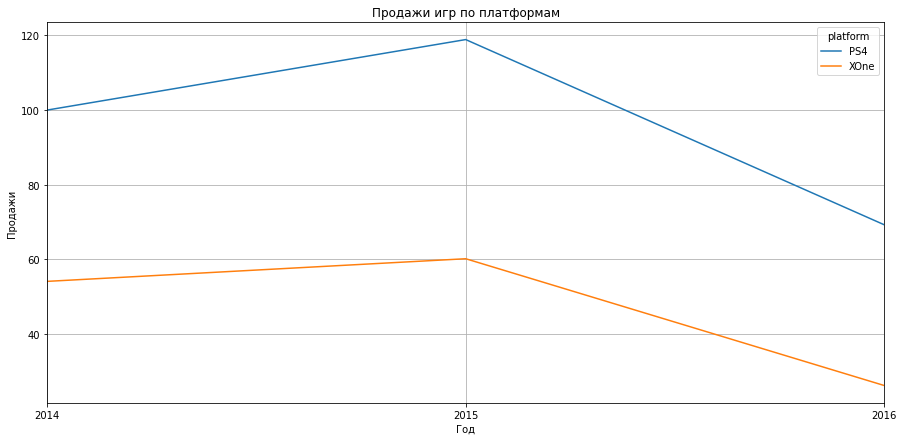

In [22]:
data_1516.query('platform == ["PS4", "XOne"]').pivot_table(index='year_of_release', columns = 'platform', values='all_sales', aggfunc='sum').plot(grid=True, figsize=(15, 7))
plt.xlabel('Год')
plt.ylabel('Продажи')
plt.title('Продажи игр по платформам')
plt.show()

Исходя из этого графика можно сказать, что наиболее прибыльными платформами стоит считать PS4 и XOne, продажи второго существенно ниже, но всё ещё весомы

Новые платформы появляются примерно раз в год, старые перестают использоваться постепенно, за исключением Nintendo, те перестали использоваться в один год.

### "Ящик с усами" по глобальным продажам игр в разбивке по платформам

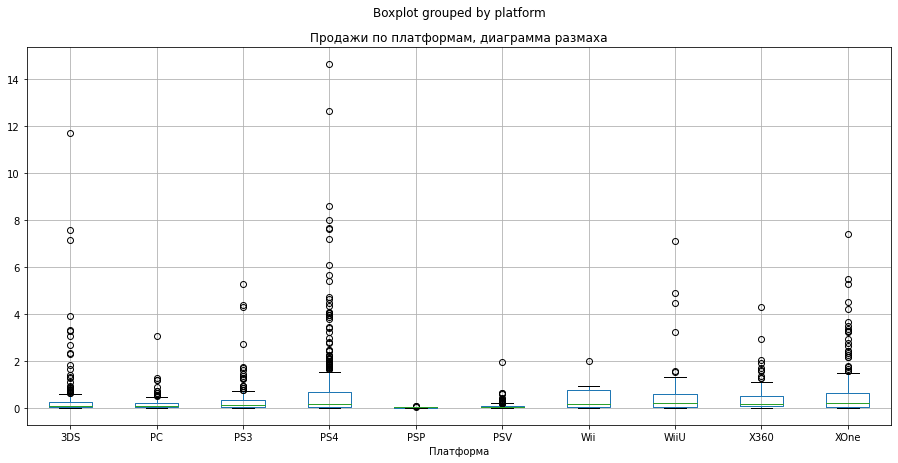

In [23]:
data_1516.boxplot(column = 'all_sales', by = 'platform', figsize = (15, 7))
plt.title('Продажи по платформам, диаграмма размаха')
plt.xlabel('Платформа')
plt.show()

In [24]:
data_1516.groupby('platform')['all_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PC,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
PS3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
PSP,13.0,0.027692,0.027735,0.01,0.0100,0.020,0.0200,0.09
PSV,295.0,0.075932,0.141591,0.01,0.0200,0.040,0.0900,1.96
Wii,11.0,0.460909,0.625451,0.01,0.0350,0.180,0.7550,2.01
WiiU,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
X360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28


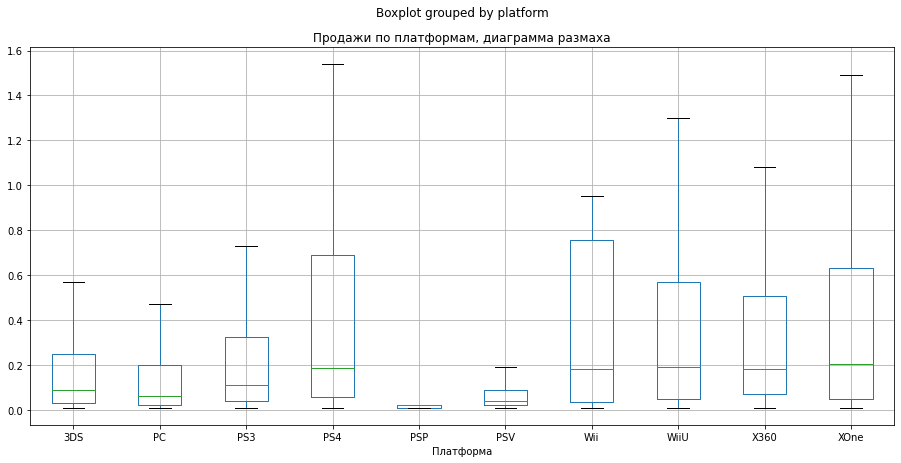

In [25]:
data_1516.boxplot(column = 'all_sales', by = 'platform', figsize = (15, 7), showfliers=False )
plt.title('Продажи по платформам, диаграмма размаха')
plt.xlabel('Платформа')
plt.show()

На диаграмме размаха можно наблюдать некоторые значения, которые сильно большие. Однако удалять их не имеет смысла, так как возможно, игра была просто очень популярна. Если смотреть на диаграмму размаха без выбросов, то можно сказать, что медиана не превышает 0.3 млн. продаж. Также можно отметить, что наибольшая верхняя граница у таких платформ как PS4, XOne и WiiU, а значит и количество игр с наибольшим числом продаж там было больше.

### Влияние на продажи внутри одной популярной платформы отзывы пользователей и критиков

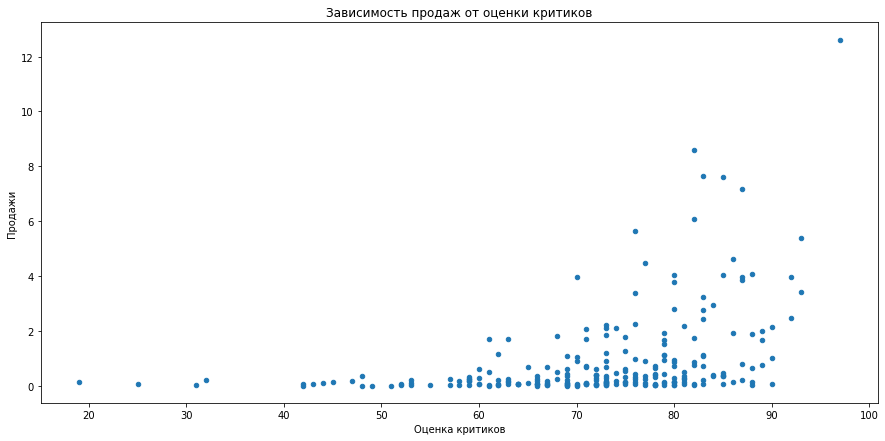

In [26]:
data_1516.query('platform == "PS4" and critic_score != "unknown"').plot(kind = 'scatter', x = 'critic_score', y = 'all_sales', figsize = (15,7))
plt.ylabel('Продажи')
plt.xlabel('Оценка критиков')
plt.title('Зависимость продаж от оценки критиков')
plt.show()

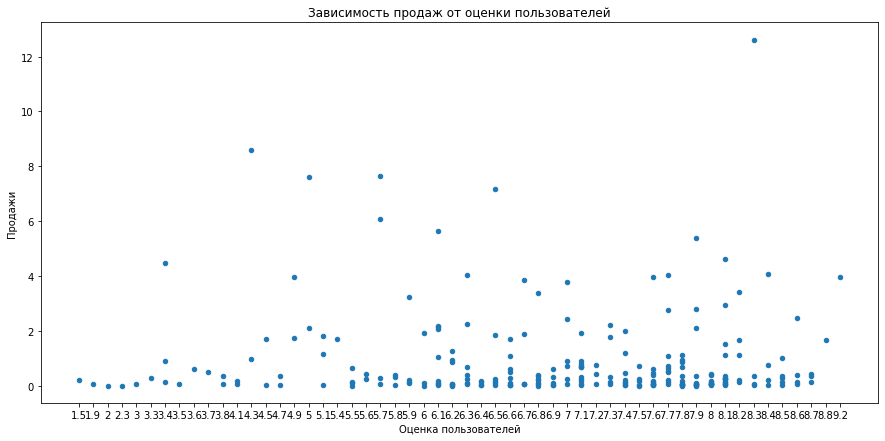

In [27]:
data_1516.query('platform == "PS4" and user_score != "unknown"').sort_values(by='user_score').plot(kind = 'scatter', x = 'user_score', y = 'all_sales', figsize = (15,7))
plt.ylabel('Продажи')
plt.xlabel('Оценка пользователей')
plt.title('Зависимость продаж от оценки пользователей')
plt.show()

In [28]:
data_ts = data_1516.query('platform == "PS4" and critic_score != "unknown"')
data_ts['all_sales'].corr(data_ts['critic_score'].astype('float'))

0.40266141068104083

In [29]:
data_ts = data_1516.query('platform == "PS4" and user_score != "unknown"')
data_ts['all_sales'].corr(data_ts['user_score'].astype('float'))

-0.040131589472697356

Корреляция между отзывами критиков и продажами слабо положительная, между отзывами пользователей и продажами очень слабо отрицательная, а значит мы не будем брать их в расчёт и говорить о какой-либо зависимости

### Соотнесём выводы с продажами на других платформах

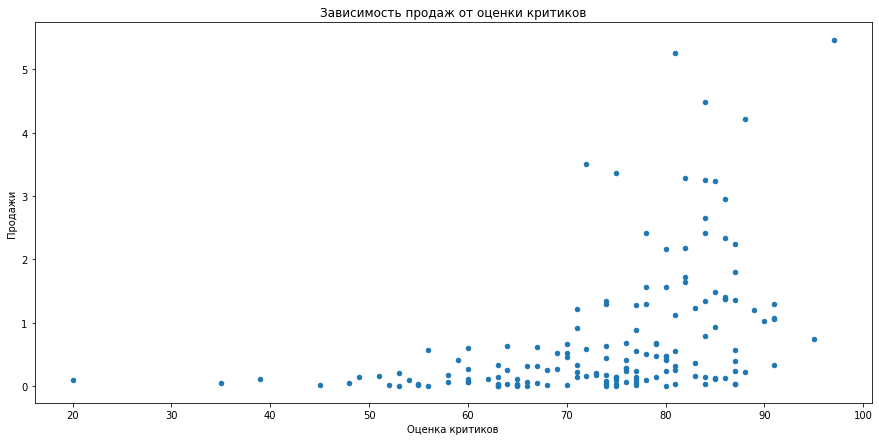

In [30]:
#Проведём те же действиям с двумя другими платформами: XOne и WiiU, а затем сравним результаты
data_1516.query('platform == "XOne" and critic_score != "unknown"').plot(kind = 'scatter', x = 'critic_score', y = 'all_sales', figsize = (15,7))
plt.ylabel('Продажи')
plt.xlabel('Оценка критиков')
plt.title('Зависимость продаж от оценки критиков')
plt.show()

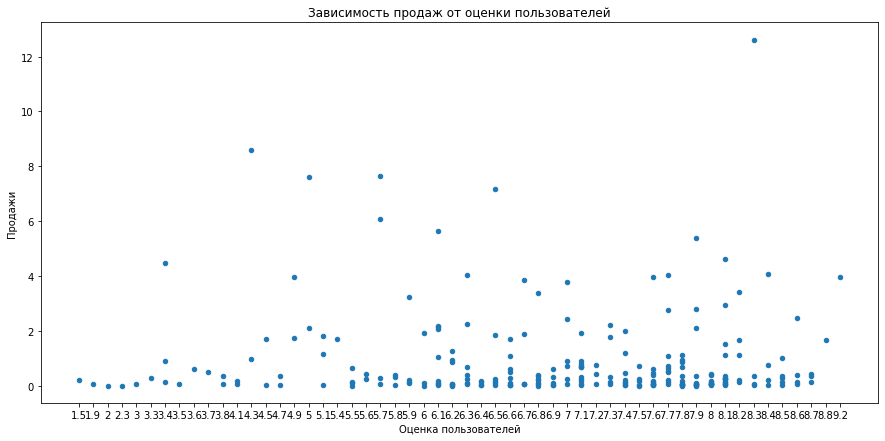

In [31]:
data_1516.query('platform == "PS4" and user_score != "unknown"').sort_values(by='user_score').plot(kind = 'scatter', x = 'user_score', y = 'all_sales', figsize = (15,7))
plt.ylabel('Продажи')
plt.xlabel('Оценка пользователей')
plt.title('Зависимость продаж от оценки пользователей')
plt.show()

In [32]:
data_ts = data_1516.query('platform == "XOne" and critic_score != "unknown"')
data_ts['all_sales'].corr(data_ts['critic_score'].astype('float'))

0.42867694370333226

In [33]:
data_ts = data_1516.query('platform == "XOne" and user_score != "unknown"')
data_ts['all_sales'].corr(data_ts['user_score'].astype('float'))

-0.0703839280647581

Ситуации XOne и PS4 похожи, уровень корелляции одинаковый

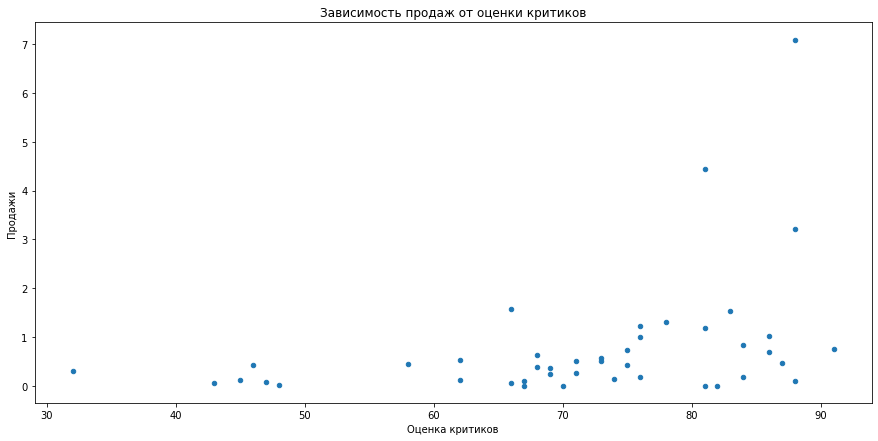

In [34]:
data_1516.query('platform == "WiiU" and critic_score != "unknown"').plot(kind = 'scatter', x = 'critic_score', y = 'all_sales', figsize = (15,7))
plt.ylabel('Продажи')
plt.xlabel('Оценка критиков')
plt.title('Зависимость продаж от оценки критиков')
plt.show()

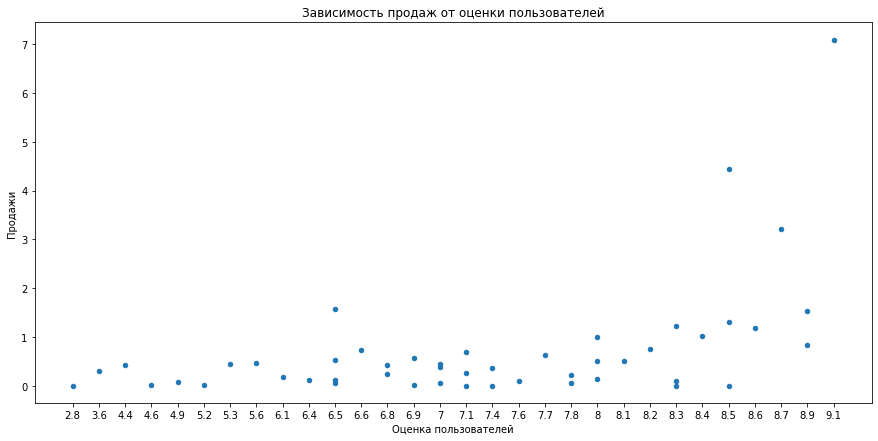

In [35]:
data_1516.query('platform == "WiiU" and user_score != "unknown"').sort_values(by='user_score').plot(kind = 'scatter', x = 'user_score', y = 'all_sales', figsize = (15,7))
plt.ylabel('Продажи')
plt.xlabel('Оценка пользователей')
plt.title('Зависимость продаж от оценки пользователей')
plt.show()

In [36]:
data_ts = data_1516.query('platform == "WiiU" and critic_score != "unknown"')
data_ts['all_sales'].corr(data_ts['critic_score'].astype('float'))

0.370201412480884

In [37]:
data_ts = data_1516.query('platform == "XOne" and user_score != "unknown"')
data_ts['all_sales'].corr(data_ts['user_score'].astype('float'))

-0.0703839280647581

Ситуации трёх изученный консолей похожи, уровень корелляции одинаковый и либо слабый, либо очень слабый, а значит говорить о зависимости между продажами и оценками критиков/пользователей мы не можем

### Распределение по жанрам. Прибыльные жанры

In [38]:
data_1516.groupby('genre')['name'].count().sort_values(ascending = False)

genre
Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: name, dtype: int64

Text(0, 0.5, 'Количество игр')

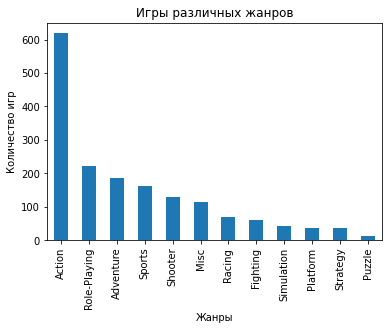

In [39]:
data_1516.groupby('genre')['all_sales'].count().sort_values(ascending = False).plot(kind = 'bar')
plt.title('Игры различных жанров')
plt.xlabel('Жанры')
plt.ylabel('Количество игр')

Больше всего выпущено игр жанра Action, Role-Playing. Меньше всего Puzzle и Strategy

In [40]:
data_1516.groupby('genre')['all_sales'].median().sort_values(ascending = False)

genre
Shooter         0.515
Sports          0.180
Platform        0.140
Fighting        0.125
Role-Playing    0.110
Simulation      0.100
Action          0.090
Misc            0.090
Racing          0.090
Strategy        0.060
Puzzle          0.045
Adventure       0.030
Name: all_sales, dtype: float64

Text(0, 0.5, 'Продажи')

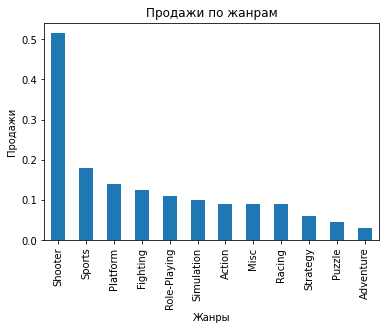

In [41]:
data_1516.groupby('genre')['all_sales'].median().sort_values(ascending = False).plot(kind = 'bar')
plt.title('Продажи по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Продажи')

В среднем наибольшее число продаж у игр жанров Shooter и Sports, наименьшее - Puzzle, Adventure.

В рамках данного этапа было установлено:
1) Пик, выпущенных игр приходится 2008-2009 года, далее количество идёт на спад.\
2) Наибольшее количество продаж на платформах PS2, X360 и PS3, наименьшее - PCFX.\
3) Новые платформы появляются примерно раз в год, старые перестают использоваться постепенно, за исключением Nintendo, те перестали использоваться в один год.\
4) В качестве актуального периода возьмём 2014 - 2016 года и в дальнейшем будем работать только с ними.\
5) Исходя из этого графика можно сказать, что наиболее прибыльными платформами стоит считать PS4 и XOne, продажи второго существенно ниже, но всё ещё весомы.\
6) Был построен "Ящик с усами" по глобальным продажам игр в разбивке по платформам.\
7) Ситуации трёх изученный консолей похожи, уровень корелляции одинаковый и либо слабый, либо очень слабый, а значит говорить о зависимости между продажами и оценками критиков/пользователей мы не можем\
8) Если смотреть на диаграмму размаха без выбросов, то можно сказать, что медиана не превышает 0.3 млн. продаж. Также можно отметить, что наибольшая верхняя граница у таких платформ как PS4, XOne и WiiU, а значит и количество игр с наибольшим числом продаж там было больше.\
9) В среднем наибольшее число продаж у игр жанров Shooter и Sports, наименьшее - Puzzle, Adventure.


## Портрет пользователя каждого региона

### Европа

In [42]:
data_1516.groupby('platform')['eu_sales'].sum().sort_values(ascending = False)

platform
PS4     130.04
XOne     46.25
PS3      25.54
PC       17.97
3DS      16.12
X360     15.49
WiiU     13.15
PSV       3.53
Wii       2.59
PSP       0.00
Name: eu_sales, dtype: float64

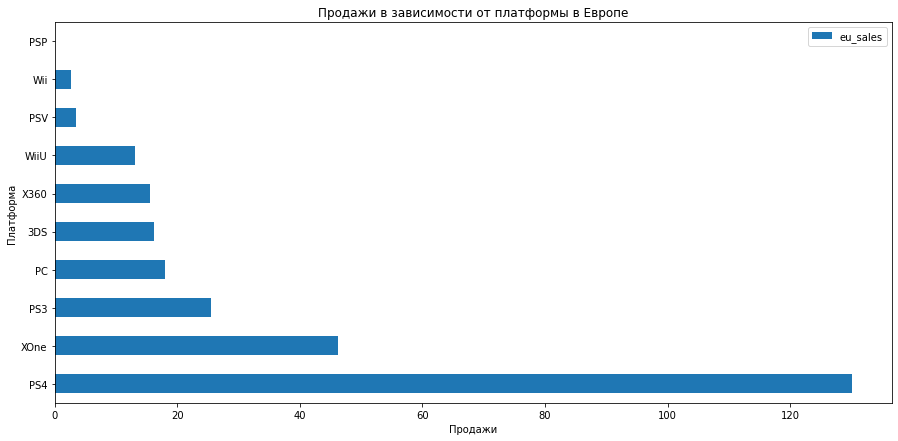

In [43]:
data_1516.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Продажи в зависимости от платформы в Европе')
plt.ylabel('Платформа')
plt.xlabel('Продажи')
plt.show()

Наибольшее число продаж для консолей - PS4 и XOne. Далее следует уже устаревшее PS3 и PC

In [44]:
data_1516.groupby('genre')['eu_sales'].sum().sort_values(ascending = False)

genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Misc            12.86
Simulation       7.30
Platform         6.80
Fighting         6.69
Adventure        6.49
Strategy         1.79
Puzzle           0.52
Name: eu_sales, dtype: float64

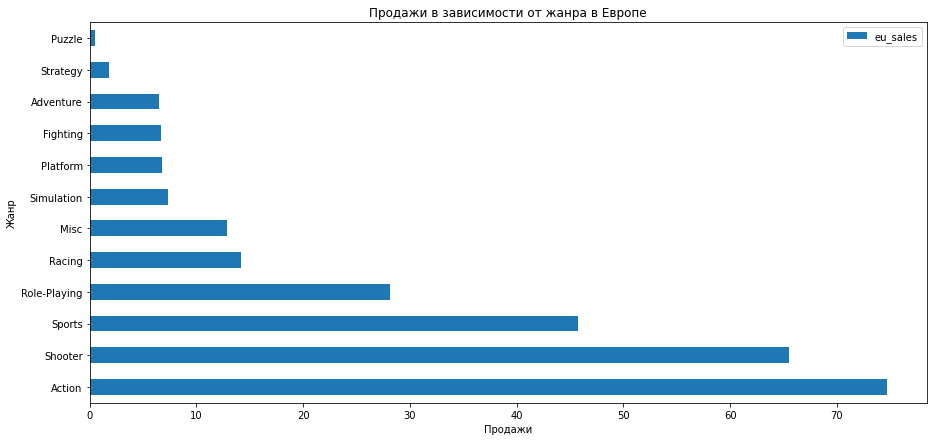

In [45]:
data_1516.groupby('genre')['eu_sales'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Продажи в зависимости от жанра в Европе')
plt.ylabel('Жанр')
plt.xlabel('Продажи')
plt.show()

Самые популярные жанры: Action, Shooter, Sports

In [46]:
data_1516.groupby('rating')['eu_sales'].sum().sort_values(ascending = False)

rating
M          93.44
unknown    58.95
E          58.06
T          34.07
E10+       26.16
Name: eu_sales, dtype: float64

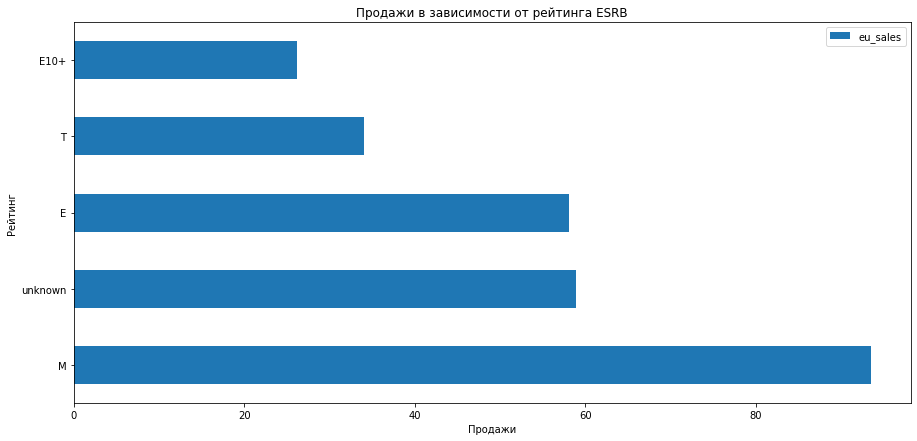

In [47]:
data_1516.groupby('rating')['eu_sales'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Продажи в зависимости от рейтинга ESRB')
plt.ylabel('Рейтинг')
plt.xlabel('Продажи')
plt.show()

Говорить о зависимости от рейтинга нельзя, т.к. с одной стороны большая доля продаж приходится как на рейтинг для взрослых(M), так и на детский(E), а также довольно для большого числа игр рейтинг не известен

### Япония


In [48]:
data_1516.groupby('platform')['jp_sales'].sum().sort_values(ascending = False)

platform
3DS     44.24
PS4     15.02
PSV     14.54
PS3     11.22
WiiU     7.31
PSP      0.36
XOne     0.32
X360     0.08
PC       0.00
Wii      0.00
Name: jp_sales, dtype: float64

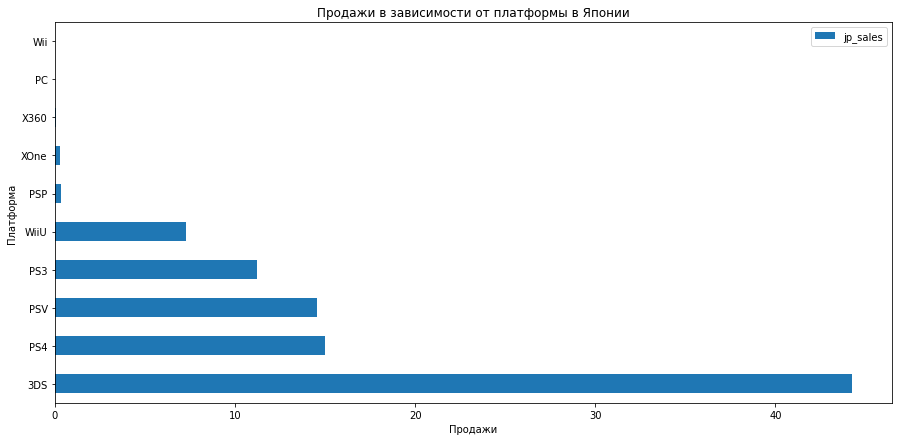

In [49]:
data_1516.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Продажи в зависимости от платформы в Японии')
plt.ylabel('Платформа')
plt.xlabel('Продажи')
plt.show()

Наибольшее число продаж для консолей и игровых приставок - Nintendo 3DS и PS4. В отличие от Европы здесь популярен Nintendo, и практически не используется XOne. Xbox исторически не прижился в Японии

In [50]:
data_1516.groupby('genre')['jp_sales'].sum().sort_values(ascending = False)

genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Adventure        3.60
Sports           3.26
Platform         2.69
Simulation       2.31
Racing           1.76
Strategy         0.95
Puzzle           0.93
Name: jp_sales, dtype: float64

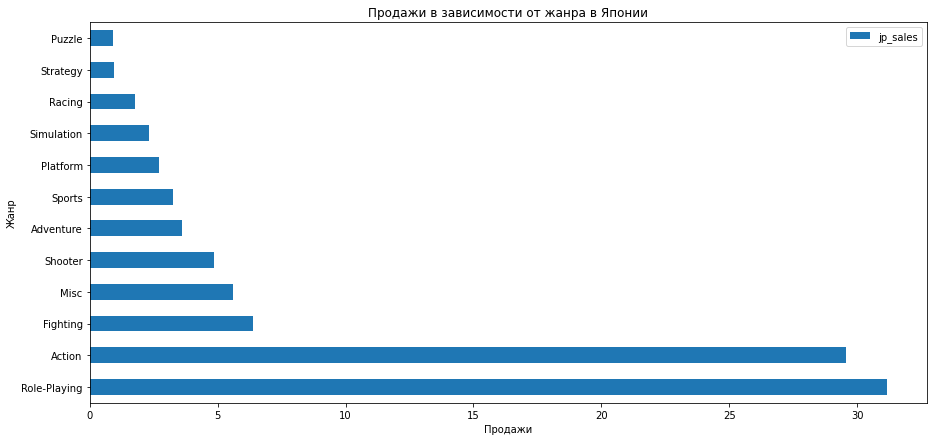

In [51]:
data_1516.groupby('genre')['jp_sales'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Продажи в зависимости от жанра в Японии')
plt.ylabel('Жанр')
plt.xlabel('Продажи')
plt.show()

Наибольшее число продаж у жанров Action и Role-Playing

In [52]:
data_1516.groupby('rating')['jp_sales'].sum().sort_values(ascending = False)

rating
unknown    56.90
T          14.78
E           8.94
M           8.01
E10+        4.46
Name: jp_sales, dtype: float64

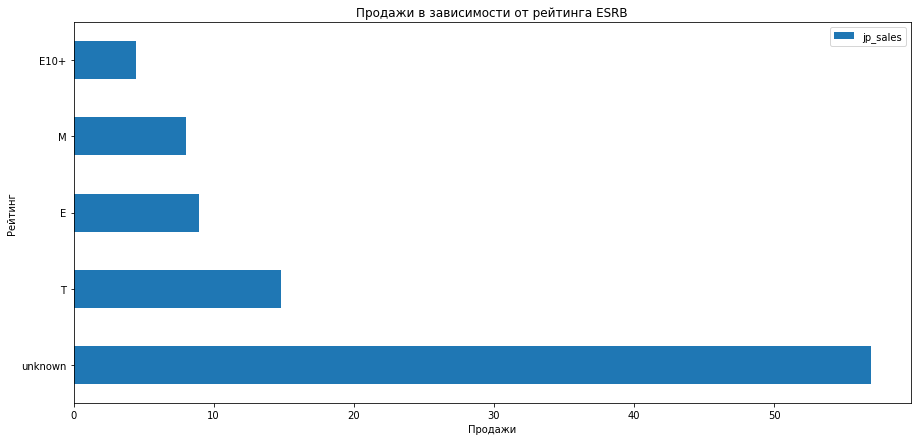

In [53]:
data_1516.groupby('rating')['jp_sales'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Продажи в зависимости от рейтинга ESRB')
plt.ylabel('Рейтинг')
plt.xlabel('Продажи')
plt.show()

Говорить о зависимости между рейтингом и продажами нельзя, т.к. у более 60% он неизвестен

### Северная Америка

In [54]:
data_1516.groupby('platform')['na_sales'].sum().sort_values(ascending = False)

platform
PS4     98.61
XOne    81.27
X360    28.30
3DS     22.64
PS3     22.05
WiiU    19.36
PC       7.23
PSV      2.52
Wii      2.08
PSP      0.00
Name: na_sales, dtype: float64

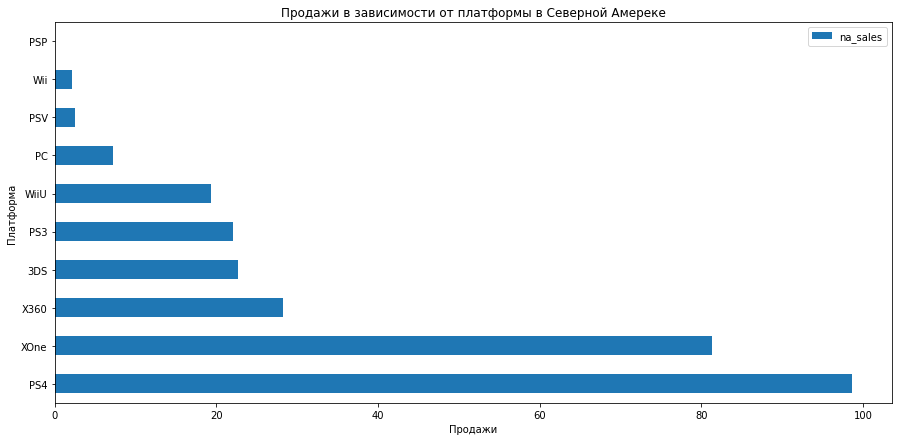

In [55]:
data_1516.groupby('platform')['na_sales'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Продажи в зависимости от платформы в Северной Амереке')
plt.ylabel('Платформа')
plt.xlabel('Продажи')
plt.show()

Ситуация похожа на Европу: наибольшее число продаж у консолей PS4 и XOne

In [56]:
data_1516.groupby('genre')['na_sales'].sum().sort_values(ascending = False)

genre
Shooter         79.02
Action          72.53
Sports          46.13
Role-Playing    33.47
Misc            15.05
Fighting        12.43
Racing           8.74
Platform         6.79
Adventure        5.64
Simulation       2.63
Strategy         0.98
Puzzle           0.65
Name: na_sales, dtype: float64

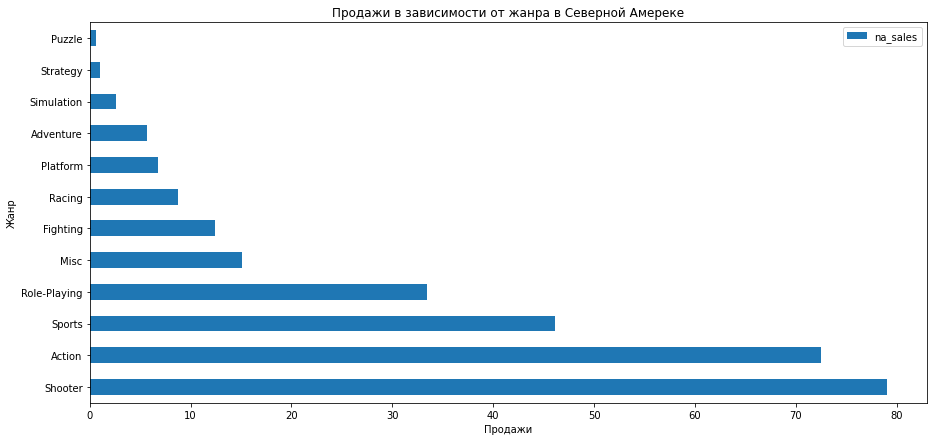

In [57]:
data_1516.groupby('genre')['na_sales'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Продажи в зависимости от жанра в Северной Амереке')
plt.ylabel('Жанр')
plt.xlabel('Продажи')
plt.show()

Самые популярные жанры: Shooter, Action, Sports

In [58]:
data_1516.groupby('rating')['na_sales'].sum().sort_values(ascending = False)

rating
M          96.42
unknown    64.72
E          50.74
T          38.95
E10+       33.23
Name: na_sales, dtype: float64

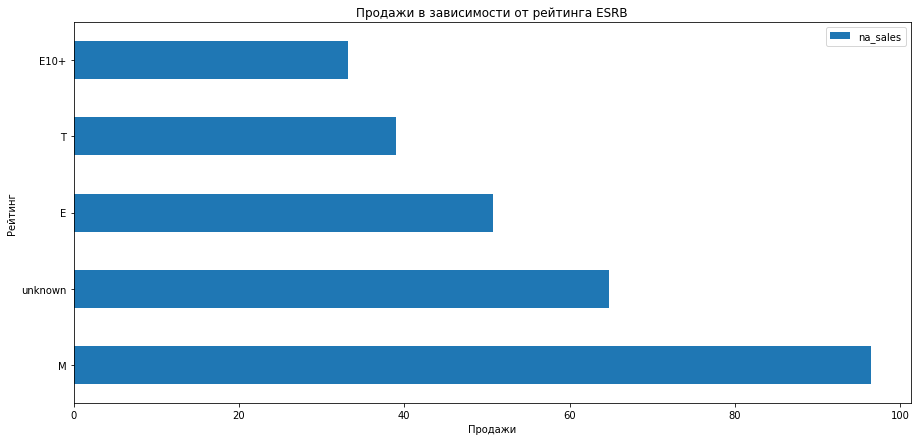

In [59]:
data_1516.groupby('rating')['na_sales'].sum().sort_values(ascending = False).plot(kind = 'barh', legend = True, figsize = (15, 7))
plt.title('Продажи в зависимости от рейтинга ESRB')
plt.ylabel('Рейтинг')
plt.xlabel('Продажи')
plt.show()

Говорить о зависимости от рейтинга нельзя, т.к. с одной стороны большая доля продаж приходится как на рейтинг для взрослых(M), так и на детский(E), а также довольно для большого числа игр рейтинг не известен

Промежуточные выводы:
Портреты пользователей Северной Америки и Европы совпадают: наибольшее число продаж у консолей PS4 и XOne, самые популярные жанры: Shooter, Action, Sports. Японцы же отличаются: Наибольшее число продаж для консолей и игровых приставок - Nintendo 3DS и PS4., а наиболее популярные жанры: Action и Role-Playing\
Говорить о зависимости между возрастным рейтингом и продажами нельзя ни в одном из регионов

## Проверка гипотез

### Первая гипотеза
Гипотеза H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые\
Альтернативная: Средние пользовательские рейтинги платформ Xbox One и PC не равны

In [60]:
results = scipy.stats.ttest_ind(data_1516.query('platform == "PC" and user_score != "unknown"')['user_score'].astype('float'), data_1516.query('platform == "XOne" and user_score != "unknown"')['user_score'].astype('float'))

alpha = 0.05 #Задаём уровень статистической важности
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.10450507919348415
Нет оснований отвергнуть нулевую гипотезу


Раз нет оснований отвергать нулевую гипотезу, то есть основания говорить, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые

### Вторая гипотеза
Гипотеза H0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые. \
Альтернативная: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [61]:
results = scipy.stats.ttest_ind(data_1516.query('genre == "Action" and user_score != "unknown"')['user_score'].astype('float'), data_1516.query('genre == "Sports"and user_score != "unknown"')['user_score'].astype('float'))

alpha = 0.05 #Задаём уровень статистической важности
print(f'p-value: {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.8711147985105864e-19
Отвергаем нулевую гипотезу.


Раз мы отвергаем нулевую гипотезу, то есть основания полагать, что  Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Для проверки гипотез я использовал `scipy.stats.ttest_ind`, т.к. у нас есть две независимые совокупности, чьи средние мы сравниваем

## Вывод

В рамках данной работы был изучен датафрейм с данными интернет-магазина по продаже компьютерных игр. Датафрейм были проверен на пропуски и дубликаты. Пропуски были обработны, дубликаты не обнаружены. Далее были проанализированы данные. Основные выводы:
1) Пик, выпущенных игр приходится 2008-2009 года, далее количество идёт на спад.\
2) Наибольшее количество продаж на платформах PS2, X360 и PS3, наименьшее - PCFX.\
3) Новые платформы появляются примерно раз в год, старые перестают использоваться постепенно, за исключением Nintendo, те перестали использоваться в один год.\
4) В качестве актуального периода возьмём 2014 - 2016 года и в дальнейшем будем работать только с ними.\
5) Исходя из этого графика можно сказать, что наиболее прибыльными платформами стоит считать PS4 и XOne, продажи второго существенно ниже, но всё ещё весомы.\
6) Был построен "Ящик с усами" по глобальным продажам игр в разбивке по платформам.\
7) Ситуации трёх изученный консолей похожи, уровень корелляции одинаковый и либо слабый, либо очень слабый, а значит говорить о зависимости между продажами и оценками критиков/пользователей мы не можем\
8) Если смотреть на диаграмму размаха без выбросов, то можно сказать, что медиана не превышает 0.3 млн. продаж. Также можно отметить, что наибольшая верхняя граница у таких платформ как PS4, XOne и WiiU, а значит и количество игр с наибольшим числом продаж там было больше.\
9) В среднем наибольшее число продаж у игр жанров Shooter и Sports, наименьшее - Puzzle, Adventure.\
\
Портреты пользователей Северной Америки и Европы совпадают: наибольшее число продаж у консолей PS4 и XOne, самые популярные жанры: Shooter, Action, Sports. Японцы же отличаются: Наибольшее число продаж для консолей и игровых приставок - Nintendo 3DS и PS4., а наиболее популярные жанры: Action и Role-Playing. Говорить о зависимости между возрастным рейтингом и продажами нельзя ни в одном из регионов.\
И наконец были проверены две гипотезы:
1) Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые. - мы отвергаем нулевую гипотезу, то есть основания полагать, что Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.\
2) Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - нет оснований отвергать нулевую гипотезу, то есть основания говорить, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые\
\
В 2017 году в плане платформ стоить обратить внимание на две: XOne и PS4, они наиболее популярные на данный момент, однако если говорить про Японию, то можно подумать и про Nintendo 3DS (PS4 популярна во всех регионах). В плане жанров стоит обратить внимание на Action, он встречался во всех 3-х проанализированных регионах, либо же Shooter и Sports для СА и Европы / Role-Playing для Японии